Отнормируем значения временного ряда, выделим ключевые факторы и применим решающие деревья для более точного прогнозирования

![Catboost](1_22.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

In [2]:
def smape(A, F):
    return 100*np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

* Date, Matlab format
* Hour (data averaged inbetween this hour and the next one)
* Decided Daily Production Program (MWh)	
* Projected Remaining Load Amount to Balancing Units (MWh)	
* Get load Amount for Prior Day Supply Demand Balance (MWh)	
* Load Shedding Amount for Prior Day Supply Demand Balance (MWh)	
* "System Marginal Price (SMF (TL))"

In [3]:
data = pd.read_csv("https://video.ittensive.com/time-series/ittensive.time.series.03.csv",
                   delimiter=",", header=0, names=["Дата", "Час", "DDPP", "PRLA", "GLA", "LSA", "SMF"])
data = data.reset_index().drop(labels="index", axis=1)[::-1]
data.head()

,Дата,Час,DDPP,PRLA,GLA,LSA,SMF
8758,733743,0,16535,17202,666,0,165.10
8757,733743,1,17434,16001,0,1433,56.66
8756,733743,2,18212,15361,0,2851,43.29
8755,733743,3,18405,14850,0,3729,26.40
8754,733743,4,18408,14549,0,4049,26.40


Приведем дату к дате, выделим дни недели, добавим 4 предыдущих значения и рассчитаем 5 производных

In [4]:
data["Дата"] = pd.to_datetime((data["Дата"]-719050)*86400000000000)
data["WD"] = data["Дата"].dt.weekday
data["diff1"] = data["PRLA"].diff()
for i in range(1, 5):
    data["PRLA" + str(i)] = data["PRLA"].shift(i)
    data["diff" + str(i+1)] = data["diff" + str(i)].diff()
data.head()

,Дата,Час,DDPP,PRLA,GLA,LSA,SMF,WD,diff1,PRLA1,diff2,PRLA2,diff3,PRLA3,diff4,PRLA4,diff5
8758,2010-03-25,0,16535,17202,666,0,165.10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8757,2010-03-25,1,17434,16001,0,1433,56.66,3,-1201.0,17202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8756,2010-03-25,2,18212,15361,0,2851,43.29,3,-640.0,16001.0,561.0,17202.0,NaN,NaN,NaN,NaN,NaN
8755,2010-03-25,3,18405,14850,0,3729,26.40,3,-511.0,15361.0,129.0,16001.0,-432.0,17202.0,NaN,NaN,NaN
8754,2010-03-25,4,18408,14549,0,4049,26.40,3,-301.0,14850.0,210.0,15361.0,81.0,16001.0,513.0,17202.0,NaN


Отнормируем данные

In [5]:
x_columns = ["PRLA", "PRLA1", "PRLA2", "PRLA3", "PRLA4", "Час", "WD", "diff1", "diff2", "diff3", "diff4", "diff5"]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[x_columns][5:])

## Находим корреляцию параметров

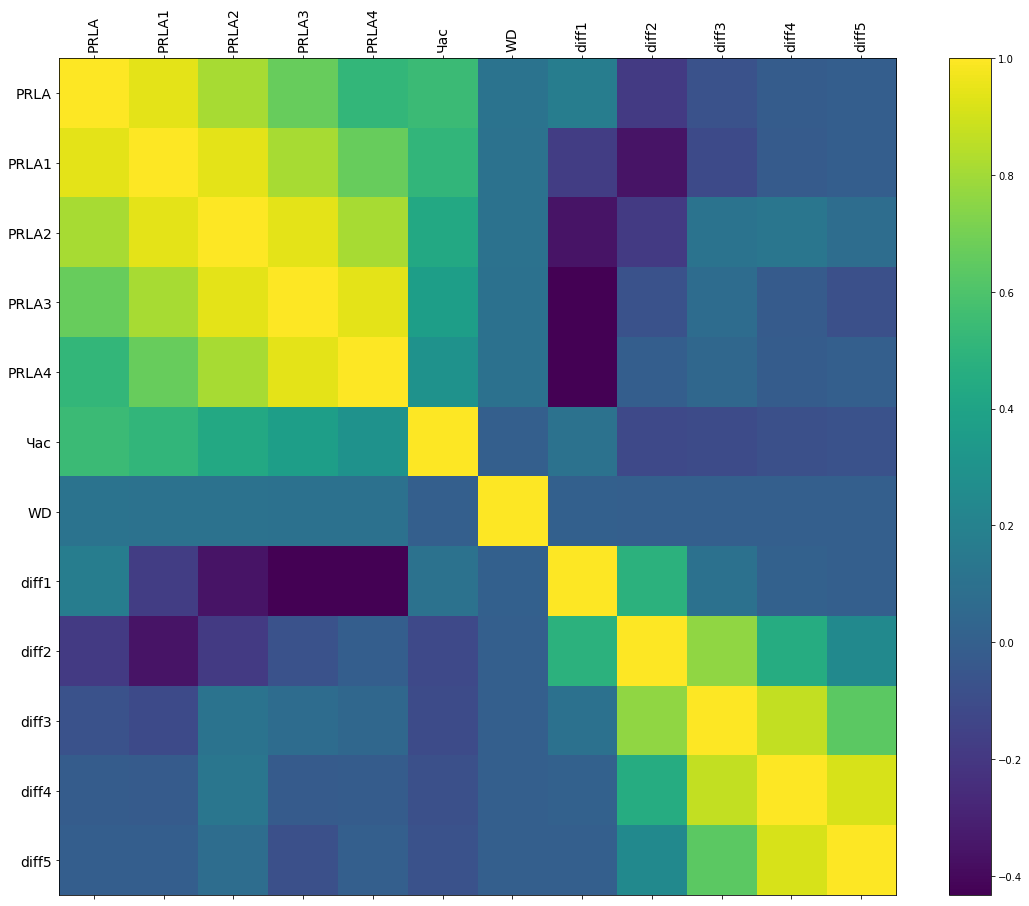

In [6]:
f = plt.figure(figsize=(19, 15))
data_corr = pd.DataFrame(data_scaled).corr()
plt.matshow(data_corr, fignum=f.number)
plt.xticks(range(len(x_columns)), x_columns, fontsize=14, rotation=90)
plt.yticks(range(len(x_columns)), x_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

In [7]:
feature_list = []
for i,c in enumerate(data_corr[0]):
    if (c>0.5 or c<-0.5) and i>0:
        feature_list.append(x_columns[i])
print ("Перспективные факторы: " + ', '.join(feature_list))

Перспективные факторы: PRLA1, PRLA2, PRLA3, PRLA4, Час


## Обучение модели

In [8]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x = scaler_x.fit_transform(data[feature_list][5:-24])
y = scaler_y.fit_transform(np.array(data["PRLA"][5:-24]).reshape(-1, 1))
model = CatBoostRegressor(iterations=1000, depth=16, verbose=True).fit(x, y)

Learning rate set to 0.057658
0:	learn: 0.9486072	total: 2.05s	remaining: 34m 10s
1:	learn: 0.9000125	total: 3.2s	remaining: 26m 38s
2:	learn: 0.8547841	total: 4.32s	remaining: 23m 54s
3:	learn: 0.8127140	total: 5.44s	remaining: 22m 34s
4:	learn: 0.7724099	total: 6.69s	remaining: 22m 11s
5:	learn: 0.7359079	total: 6.71s	remaining: 18m 31s
6:	learn: 0.6998006	total: 8s	remaining: 18m 54s
7:	learn: 0.6659382	total: 9.35s	remaining: 19m 19s
8:	learn: 0.6340328	total: 10.6s	remaining: 19m 22s
9:	learn: 0.6044667	total: 11.8s	remaining: 19m 27s
10:	learn: 0.5759896	total: 13.1s	remaining: 19m 36s
11:	learn: 0.5489762	total: 14.3s	remaining: 19m 40s
12:	learn: 0.5239615	total: 15.6s	remaining: 19m 44s
13:	learn: 0.5009942	total: 16.9s	remaining: 19m 47s
14:	learn: 0.4791461	total: 17.2s	remaining: 18m 48s
15:	learn: 0.4586559	total: 18.4s	remaining: 18m 50s
16:	learn: 0.4385959	total: 19.6s	remaining: 18m 51s
17:	learn: 0.4198125	total: 20.7s	remaining: 18m 51s
18:	learn: 0.4023307	total: 22

153:	learn: 0.1232114	total: 3m 11s	remaining: 17m 29s
154:	learn: 0.1230333	total: 3m 12s	remaining: 17m 28s
155:	learn: 0.1228110	total: 3m 13s	remaining: 17m 27s
156:	learn: 0.1223987	total: 3m 14s	remaining: 17m 26s
157:	learn: 0.1221828	total: 3m 16s	remaining: 17m 25s
158:	learn: 0.1219165	total: 3m 17s	remaining: 17m 24s
159:	learn: 0.1216020	total: 3m 18s	remaining: 17m 23s
160:	learn: 0.1212776	total: 3m 19s	remaining: 17m 22s
161:	learn: 0.1209642	total: 3m 21s	remaining: 17m 21s
162:	learn: 0.1206759	total: 3m 22s	remaining: 17m 19s
163:	learn: 0.1204914	total: 3m 23s	remaining: 17m 19s
164:	learn: 0.1200512	total: 3m 25s	remaining: 17m 18s
165:	learn: 0.1198789	total: 3m 26s	remaining: 17m 17s
166:	learn: 0.1196870	total: 3m 27s	remaining: 17m 16s
167:	learn: 0.1192559	total: 3m 29s	remaining: 17m 16s
168:	learn: 0.1189418	total: 3m 30s	remaining: 17m 15s
169:	learn: 0.1186704	total: 3m 31s	remaining: 17m 14s
170:	learn: 0.1184431	total: 3m 32s	remaining: 17m 12s
171:	learn

303:	learn: 0.0944890	total: 6m 36s	remaining: 15m 8s
304:	learn: 0.0944283	total: 6m 38s	remaining: 15m 7s
305:	learn: 0.0942552	total: 6m 39s	remaining: 15m 6s
306:	learn: 0.0941390	total: 6m 41s	remaining: 15m 5s
307:	learn: 0.0939642	total: 6m 42s	remaining: 15m 4s
308:	learn: 0.0938335	total: 6m 43s	remaining: 15m 2s
309:	learn: 0.0937189	total: 6m 45s	remaining: 15m 2s
310:	learn: 0.0935932	total: 6m 47s	remaining: 15m 1s
311:	learn: 0.0933915	total: 6m 48s	remaining: 15m 1s
312:	learn: 0.0931260	total: 6m 50s	remaining: 15m
313:	learn: 0.0930039	total: 6m 51s	remaining: 14m 59s
314:	learn: 0.0928000	total: 6m 53s	remaining: 14m 58s
315:	learn: 0.0926967	total: 6m 54s	remaining: 14m 58s
316:	learn: 0.0924908	total: 6m 56s	remaining: 14m 57s
317:	learn: 0.0924389	total: 6m 57s	remaining: 14m 56s
318:	learn: 0.0922766	total: 6m 59s	remaining: 14m 55s
319:	learn: 0.0921998	total: 7m	remaining: 14m 54s
320:	learn: 0.0919535	total: 7m 2s	remaining: 14m 53s
321:	learn: 0.0918877	total:

454:	learn: 0.0794200	total: 9m 43s	remaining: 11m 38s
455:	learn: 0.0793793	total: 9m 44s	remaining: 11m 37s
456:	learn: 0.0793555	total: 9m 45s	remaining: 11m 35s
457:	learn: 0.0792564	total: 9m 46s	remaining: 11m 34s
458:	learn: 0.0792222	total: 9m 48s	remaining: 11m 33s
459:	learn: 0.0791792	total: 9m 49s	remaining: 11m 31s
460:	learn: 0.0791176	total: 9m 50s	remaining: 11m 30s
461:	learn: 0.0790452	total: 9m 51s	remaining: 11m 28s
462:	learn: 0.0789283	total: 9m 52s	remaining: 11m 27s
463:	learn: 0.0788644	total: 9m 53s	remaining: 11m 26s
464:	learn: 0.0787784	total: 9m 55s	remaining: 11m 25s
465:	learn: 0.0786133	total: 9m 56s	remaining: 11m 23s
466:	learn: 0.0784512	total: 9m 58s	remaining: 11m 22s
467:	learn: 0.0783721	total: 9m 59s	remaining: 11m 21s
468:	learn: 0.0782913	total: 10m 1s	remaining: 11m 20s
469:	learn: 0.0782510	total: 10m 2s	remaining: 11m 19s
470:	learn: 0.0781962	total: 10m 3s	remaining: 11m 18s
471:	learn: 0.0780929	total: 10m 5s	remaining: 11m 17s
472:	learn

603:	learn: 0.0687413	total: 12m 53s	remaining: 8m 27s
604:	learn: 0.0686612	total: 12m 54s	remaining: 8m 25s
605:	learn: 0.0685787	total: 12m 55s	remaining: 8m 24s
606:	learn: 0.0684830	total: 12m 57s	remaining: 8m 23s
607:	learn: 0.0684634	total: 12m 58s	remaining: 8m 22s
608:	learn: 0.0684324	total: 13m	remaining: 8m 20s
609:	learn: 0.0683562	total: 13m 1s	remaining: 8m 19s
610:	learn: 0.0683031	total: 13m 2s	remaining: 8m 18s
611:	learn: 0.0682614	total: 13m 3s	remaining: 8m 16s
612:	learn: 0.0682018	total: 13m 5s	remaining: 8m 15s
613:	learn: 0.0681325	total: 13m 6s	remaining: 8m 14s
614:	learn: 0.0680922	total: 13m 7s	remaining: 8m 13s
615:	learn: 0.0679951	total: 13m 8s	remaining: 8m 11s
616:	learn: 0.0679462	total: 13m 10s	remaining: 8m 10s
617:	learn: 0.0678633	total: 13m 11s	remaining: 8m 9s
618:	learn: 0.0678212	total: 13m 12s	remaining: 8m 7s
619:	learn: 0.0677896	total: 13m 13s	remaining: 8m 6s
620:	learn: 0.0677242	total: 13m 15s	remaining: 8m 5s
621:	learn: 0.0676870	tot

754:	learn: 0.0611406	total: 16m 6s	remaining: 5m 13s
755:	learn: 0.0610875	total: 16m 8s	remaining: 5m 12s
756:	learn: 0.0610292	total: 16m 9s	remaining: 5m 11s
757:	learn: 0.0609709	total: 16m 10s	remaining: 5m 9s
758:	learn: 0.0609572	total: 16m 11s	remaining: 5m 8s
759:	learn: 0.0609217	total: 16m 12s	remaining: 5m 7s
760:	learn: 0.0608790	total: 16m 14s	remaining: 5m 5s
761:	learn: 0.0608322	total: 16m 15s	remaining: 5m 4s
762:	learn: 0.0607823	total: 16m 16s	remaining: 5m 3s
763:	learn: 0.0607404	total: 16m 17s	remaining: 5m 2s
764:	learn: 0.0607003	total: 16m 18s	remaining: 5m
765:	learn: 0.0606526	total: 16m 20s	remaining: 4m 59s
766:	learn: 0.0606284	total: 16m 21s	remaining: 4m 58s
767:	learn: 0.0605914	total: 16m 22s	remaining: 4m 56s
768:	learn: 0.0605695	total: 16m 24s	remaining: 4m 55s
769:	learn: 0.0605392	total: 16m 25s	remaining: 4m 54s
770:	learn: 0.0605109	total: 16m 26s	remaining: 4m 53s
771:	learn: 0.0604774	total: 16m 28s	remaining: 4m 51s
772:	learn: 0.0604596	to

905:	learn: 0.0552927	total: 19m 27s	remaining: 2m 1s
906:	learn: 0.0552582	total: 19m 28s	remaining: 1m 59s
907:	learn: 0.0552184	total: 19m 29s	remaining: 1m 58s
908:	learn: 0.0551725	total: 19m 30s	remaining: 1m 57s
909:	learn: 0.0551259	total: 19m 31s	remaining: 1m 55s
910:	learn: 0.0550800	total: 19m 33s	remaining: 1m 54s
911:	learn: 0.0550239	total: 19m 34s	remaining: 1m 53s
912:	learn: 0.0549985	total: 19m 36s	remaining: 1m 52s
913:	learn: 0.0549519	total: 19m 37s	remaining: 1m 50s
914:	learn: 0.0549228	total: 19m 38s	remaining: 1m 49s
915:	learn: 0.0548679	total: 19m 39s	remaining: 1m 48s
916:	learn: 0.0548322	total: 19m 41s	remaining: 1m 46s
917:	learn: 0.0548120	total: 19m 42s	remaining: 1m 45s
918:	learn: 0.0548010	total: 19m 44s	remaining: 1m 44s
919:	learn: 0.0547881	total: 19m 45s	remaining: 1m 43s
920:	learn: 0.0547771	total: 19m 46s	remaining: 1m 41s
921:	learn: 0.0547452	total: 19m 47s	remaining: 1m 40s
922:	learn: 0.0547269	total: 19m 49s	remaining: 1m 39s
923:	learn:

## Визуализация результата

In [17]:
x_test = scaler_x.fit_transform(data[feature_list][-120:])
y_test = data["PRLA"][-120:]
forecast = scaler_y.inverse_transform(np.array(model.predict(x_test)).reshape(-1, 1))

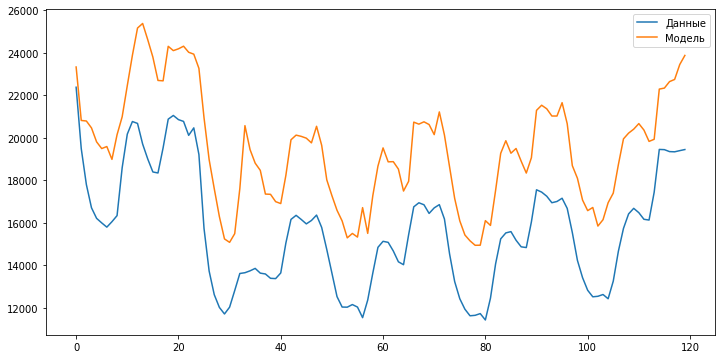

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(list(y_test))
plt.plot(forecast)
plt.legend(labels=["Данные", "Модель"])
plt.show()

Оценим ошибку

In [19]:
model_smape = smape(list(y_test[-24:]), forecast[-24:])
print ("Ошибка модели:", model_smape)

Ошибка модели: 13798.694532681338
